In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, roc_curve, auc

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [14]:
# Load the file into dataframe
df = pd.read_csv("shuffle_email_spam_classification.csv")
df.head()

,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0


In [15]:
df.shape

(5172, 3002)

In [16]:
# Check for columns with more than 0 null values
null_columns = df.columns[df.isnull().any()]

# Display columns with null values and their count if any
if (null_columns.size > 0):
    print("Columns with null values:")
    for col in null_columns:
        print(f"{col}: {df[col].isnull().sum()} null values")
else:
    print("There are no columns with null values")

There are no columns with null values


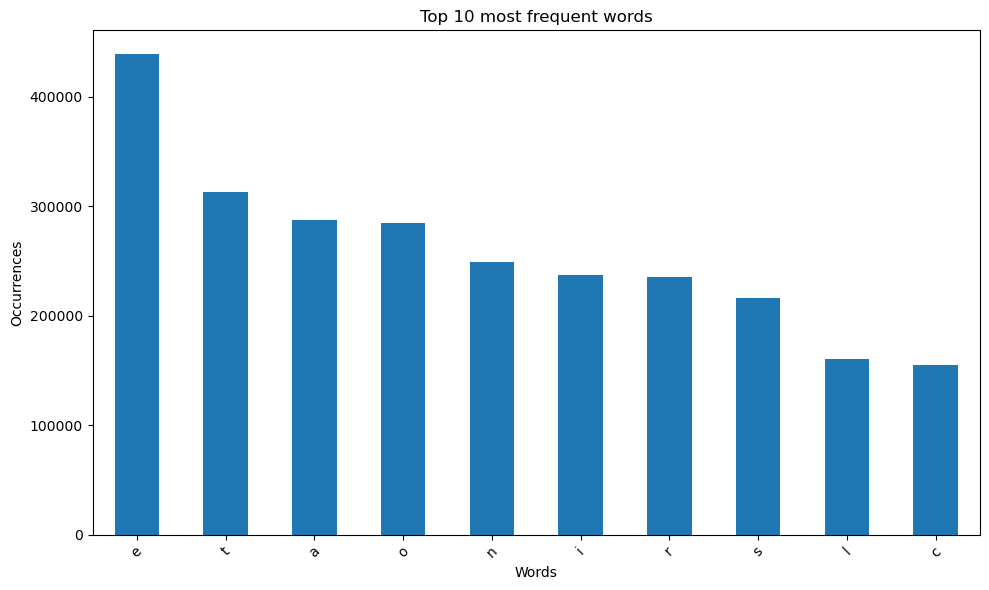

In [17]:
# Sum occurrences of each word. Exclude first and last cols
word_occurrences = df.iloc[:, 1:-1].sum(axis=0)

# Sort words by occurrences
top_words = word_occurrences.sort_values(ascending=False).head(10)

# Plot the top 10 words
plt.figure(figsize=(10, 6))
top_words.plot(kind='bar')
plt.title("Top 10 most frequent words")
plt.xlabel("Words")
plt.ylabel("Occurrences")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

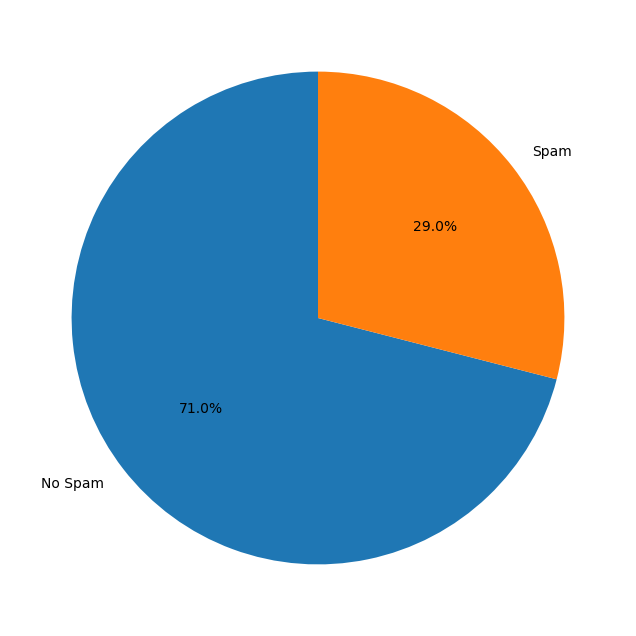

In [18]:
# Create pie chart which shows the percentage of spam emails
spam_counts = df.iloc[:, -1].value_counts()
spam_counts.plot(kind='pie', 
                   labels=spam_counts.index.map({0: 'No Spam', 1: 'Spam'}), 
                   autopct='%1.1f%%', 
                   startangle=90, 
                   figsize=(8, 8))

# Show the plot
plt.ylabel('')  # Remove the y-axis label
plt.show()

In [19]:
# Calculating correlation matrix of all columns takes too much time. 
# Reducing the number of columns by removing low-variance columns and selecting the 500 best features.

# Exclude first and last columns
X = df.iloc[:, 1:-1]

# Remove low-variance columns
selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(X)

# Get the selected feature names
selected_columns = X.columns[selector.get_support()]

# Create a new DataFrame with reduced features and column names
df_reduced = pd.DataFrame(X_reduced, columns=selected_columns)

In [20]:
df_reduced.head()

,the,to,ect,and,for,of,a,you,hou,in,...,fight,australia,plain,enhancements,connevey,jay,valued,lay,military,ff
0,0,0,1,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,13,24,6,6,2,102,1,27,18,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,8,0,0,4,...,0,0,0,0,0,0,0,0,0,0
3,0,5,22,0,5,1,51,2,10,1,...,0,0,0,0,0,0,0,0,0,0
4,7,6,17,1,5,2,57,0,9,3,...,0,0,0,0,0,0,0,0,0,1


In [21]:
y = df.iloc[:, -1]

# Selecting the 500 most important columns
selector = SelectKBest(score_func=chi2, k=500)
X_selected = selector.fit_transform(df_reduced, y)

# Get selected column names
selected_columns = df_reduced.columns[selector.get_support()]

# Create a new DataFrame with selected features and column names
df_selected = pd.DataFrame(X_selected, columns=selected_columns)

df_selected.head()

,to,ect,and,of,a,you,hou,in,on,is,...,lls,ur,ml,ward,aren,fire,corel,tm,plain,ff
0,0,1,0,0,2,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
1,13,24,6,2,102,1,27,18,21,13,...,0,24,0,3,3,0,0,0,0,1
2,0,1,0,0,8,0,0,4,2,0,...,0,0,0,0,0,0,0,0,0,0
3,5,22,0,1,51,2,10,1,5,9,...,0,1,0,7,2,0,0,0,0,0
4,6,17,1,2,57,0,9,3,12,2,...,0,5,0,3,1,0,0,0,0,1


In [22]:
# Get scores and p-values for selected features
scores = selector.scores_[selector.get_support()]
pvals = selector.pvalues_[selector.get_support()]

# Create a summary DataFrame
feature_summary = pd.DataFrame({
    'Feature': selected_columns,
    'Chi2 Score': scores,
    'P-value': pvals
}).sort_values(by='Chi2 Score', ascending=False)

# Display the top 10 features
print(feature_summary.head(10)) 

    Feature    Chi2 Score  P-value
11        i  20933.845216      0.0
17        s   9905.907062      0.0
96        r   9581.168541      0.0
4         a   8297.355495      0.0
79        o   7767.524289      0.0
130       n   6818.365184      0.0
27        e   6309.085868      0.0
77        p   6102.448757      0.0
37        t   5700.608037      0.0
32        d   4752.245232      0.0


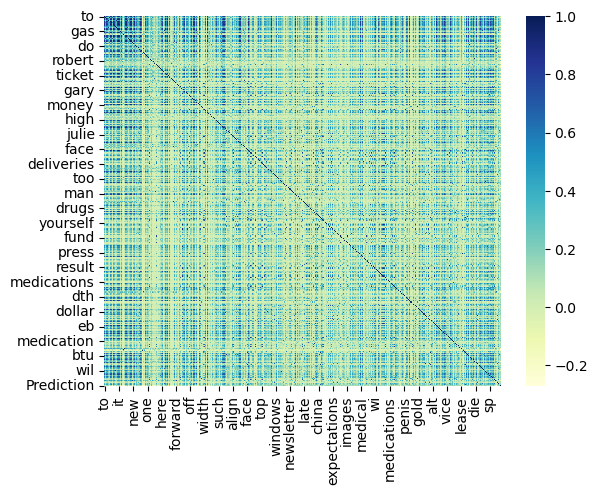

In [23]:
# Calculate and visualize the correlation matrix

# Add the prediction col for the correlation and then drop it again
df_selected['Prediction'] = y 

correlation_matrix = df_selected.corr()
sns.heatmap(correlation_matrix, cmap="YlGnBu")
plt.show()

df_selected.drop(columns='Prediction', inplace=True)

In [24]:
print("Shape of the correl matrix: " + str(correlation_matrix.shape))

correl_fe_to_Y = correlation_matrix['Prediction']
print(type(correl_fe_to_Y))
correl_fe_to_Y = correl_fe_to_Y.drop('Prediction') # Corr('Prediction', 'Prediction') = 1.0 and we do not need this information 

print(correl_fe_to_Y)

Shape of the correl matrix: (501, 501)
<class 'pandas.core.series.Series'>
to       0.055277
ect     -0.120782
and      0.114364
of       0.197234
a        0.107776
           ...   
fire     0.136669
corel    0.104321
tm       0.143377
plain    0.131170
ff       0.135479
Name: Prediction, Length: 500, dtype: float64


more     0.258152
our      0.228187
able     0.222219
best     0.221703
ur       0.220253
sex      0.220092
sec      0.217402
money    0.217215
soft     0.213382
dr       0.212413
Name: Prediction, dtype: float64


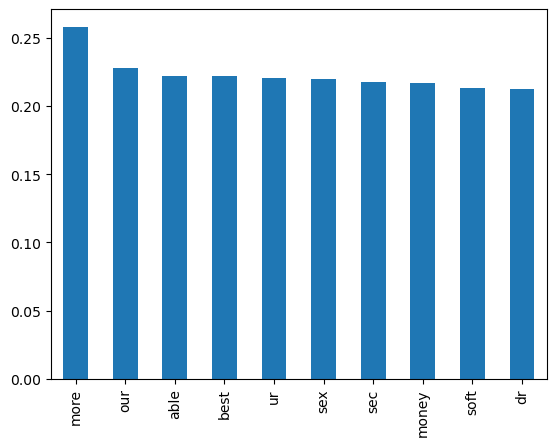

In [25]:
# Sort it and get the k best
best_features_corr = correl_fe_to_Y.nlargest(10)
print(best_features_corr)

best_features_corr.plot(kind='bar')
plt.show()

In [26]:
# Set a threshold for correlation
threshold = 0.80
to_drop = set()

# Identify highly correlated features
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            to_drop.add(colname)

# Drop the highly correlated features from df_selected
X = df_selected.drop(columns=to_drop)

print(f"Columns dropped due to high correlation: {to_drop}")
X.head()

Columns dropped due to high correlation: {'y', 'dth', 'materia', 'format', 'wil', 'gif', 'htm', 'xl', 'medication', 'investing', 'width', 'pipe', 'inherent', 'window', 're', 'ma', 'securities', 'imited', 'p', 'border', 'and', 'demokritos', 'style', 'enter', 'readers', 'in', 'darial', 'i', 'hotlist', 'event', 'is', 'html', 'risks', 've', 'ct', 'colspan', 'le', 'color', 'result', 'met', 'ti', 'c', 'ali', 'internationa', 'subscribers', 'statement', 'sp', 'ur', 'e', 'your', 'b', 'farmer', 'u', 'form', 'heal', 'eight', 'ca', 's', 'edition', 'share', 'size', 'on', 't', 'f', 'h', 'family', 'certain', 'far', 'drug', 'lease', 'pa', 'ce', 'be', 'within', 'nd', 'kin', 'info', 'un', 'stocks', 'dollar', 'at', 'hou', 'k', 'g', 'or', 'pt', 'uncertainties', 'ed', 'a', 'thank', 'arial', 'img', 'wind', 'co', 'duty', 'hot', 'btu', 'de', 'investor', 'ooking', 'ic', 'an', 'national', 'corel', 'pill', 'sr', 'hi', 'vol', 'face', 'td', 'mg', 'd', 'company', 'projections', 'valium', 'dealer', 'ad', 'v', 'inves

,to,ect,you,enron,will,with,com,gas,deal,meter,...,ut,isc,tie,mi,po,der,fire,tm,plain,ff
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,13,24,1,1,0,2,3,1,0,0,...,2,1,0,5,0,0,0,0,0,1
2,0,1,0,0,0,0,0,2,0,0,...,0,0,0,2,0,0,0,0,0,0
3,5,22,2,0,0,1,0,0,2,1,...,0,0,0,0,0,0,0,0,0,0
4,6,17,0,0,0,0,0,2,0,3,...,1,0,0,3,1,0,0,0,0,1


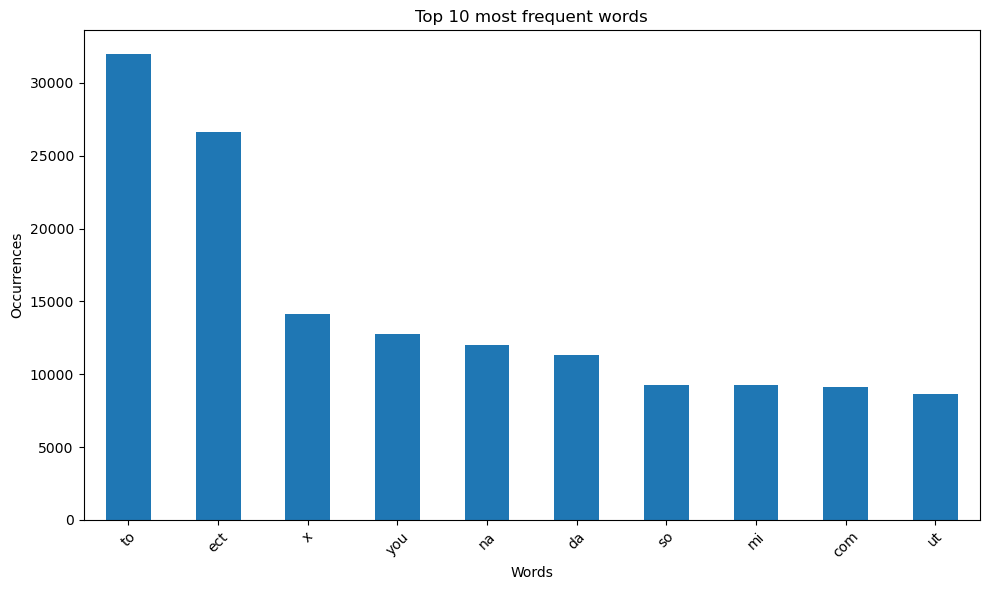

In [27]:
# Sum occurrences of each word.
word_occurrences = X.sum(axis=0)

# Sort words by occurrences
top_words = word_occurrences.sort_values(ascending=False).head(10)

# Plot the top 10 words
plt.figure(figsize=(10, 6))
top_words.plot(kind='bar')
plt.title("Top 10 most frequent words")
plt.xlabel("Words")
plt.ylabel("Occurrences")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [94]:
# Initialize models
rf = RandomForestClassifier(random_state=39)

lgbm = LGBMClassifier(random_state=39, verbose=-1)

In [95]:
# Define a function to calculate all metrics
def calculate_metrics(y_true, y_pred):
    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate

    return {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity (Recall)': recall,
        'Specificity': specificity
    }

In [96]:
# Cross-validation setup for Random Forest
kf = StratifiedKFold(n_splits=10)
rf_metrics = []

print("Random Forest Cross-Validation Results:")
for fold, (train_index, test_index) in enumerate(kf.split(X, y), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    y_score = rf.predict_proba(X_test)[:, 1]  # Predicted probabilities

    # Store fold results
    metrics = calculate_metrics(y_test, y_pred)
    metrics['Fold'] = fold
    metrics['y_true'] = list(y_test)  # Store actual labels
    metrics['y_score'] = list(y_score)  # Store probabilities
    rf_metrics.append(metrics)

# Convert to DataFrame
rf_results_df = pd.DataFrame(rf_metrics)

# Flatten the lists so we can use them for ROC calculations
rf_results_df = rf_results_df.explode(['y_true', 'y_score'])

# Convert y_true and y_score to numeric type
rf_results_df['y_true'] = rf_results_df['y_true'].astype(int)
rf_results_df['y_score'] = rf_results_df['y_score'].astype(float)

print(rf_results_df)

Random Forest Cross-Validation Results:
     TP   TN  FP  FN  Accuracy  Precision  Sensitivity (Recall)  Specificity  \
0   142  353  15   8  0.955598   0.904459              0.946667     0.959239   
0   142  353  15   8  0.955598   0.904459              0.946667     0.959239   
0   142  353  15   8  0.955598   0.904459              0.946667     0.959239   
0   142  353  15   8  0.955598   0.904459              0.946667     0.959239   
0   142  353  15   8  0.955598   0.904459              0.946667     0.959239   
..  ...  ...  ..  ..       ...        ...                   ...          ...   
9   141  347  20   9  0.943907   0.875776              0.940000     0.945504   
9   141  347  20   9  0.943907   0.875776              0.940000     0.945504   
9   141  347  20   9  0.943907   0.875776              0.940000     0.945504   
9   141  347  20   9  0.943907   0.875776              0.940000     0.945504   
9   141  347  20   9  0.943907   0.875776              0.940000     0.945504   


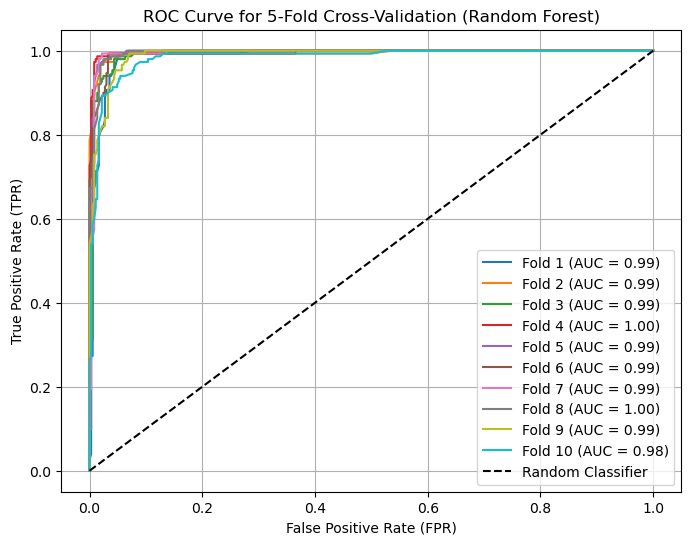

In [97]:
TP = rf_results_df["TP"].values
TN = rf_results_df["TN"].values
FP = rf_results_df["FP"].values
FN = rf_results_df["FN"].values

# Compute False Positive Rate (FPR) and True Positive Rate (TPR)
FPR = FP / (FP + TN)
TPR = TP / (TP + FN)

plt.figure(figsize=(8, 6))
folds = rf_results_df['Fold'].unique()
auc_scores = []

for fold in folds:
    fold_data = rf_results_df[rf_results_df['Fold'] == fold]
    y_true = fold_data['y_true'].values
    y_score = fold_data['y_score'].values

    # Compute ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)

    # Plot ROC for this fold
    plt.plot(fpr, tpr, label=f'Fold {fold} (AUC = {roc_auc:.2f})')

# Plot diagonal (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

# Plot settings
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for 5-Fold Cross-Validation (Random Forest)")
plt.legend()
plt.grid()

plt.show()

In [98]:
# Cross-validation setup for LGBM
kf = StratifiedKFold(n_splits=10)
lgbm_metrics = []

print("LGBM Cross-Validation Results:")
for fold, (train_index, test_index) in enumerate(kf.split(X, y), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)  # Hard predictions (not used for ROC)
    y_score = lgbm.predict_proba(X_test)[:, 1]  # **Predicted probabilities**

    # Store fold results
    metrics = calculate_metrics(y_test, y_pred)
    metrics['Fold'] = fold
    metrics['y_true'] = list(y_test)  # Store actual labels
    metrics['y_score'] = list(y_score)  # Store probabilities
    lgbm_metrics.append(metrics)

# Convert to DataFrame
lgbm_results_df = pd.DataFrame(lgbm_metrics)

# Flatten the lists so we can use them for ROC calculations
lgbm_results_df = lgbm_results_df.explode(['y_true', 'y_score'])

# Convert y_true and y_score to numeric type
lgbm_results_df['y_true'] = lgbm_results_df['y_true'].astype(int)
lgbm_results_df['y_score'] = lgbm_results_df['y_score'].astype(float)

print(lgbm_results_df)

LGBM Cross-Validation Results:
     TP   TN  FP  FN  Accuracy  Precision  Sensitivity (Recall)  Specificity  \
0   141  355  13   9  0.957529   0.915584              0.940000     0.964674   
0   141  355  13   9  0.957529   0.915584              0.940000     0.964674   
0   141  355  13   9  0.957529   0.915584              0.940000     0.964674   
0   141  355  13   9  0.957529   0.915584              0.940000     0.964674   
0   141  355  13   9  0.957529   0.915584              0.940000     0.964674   
..  ...  ...  ..  ..       ...        ...                   ...          ...   
9   140  343  24  10  0.934236   0.853659              0.933333     0.934605   
9   140  343  24  10  0.934236   0.853659              0.933333     0.934605   
9   140  343  24  10  0.934236   0.853659              0.933333     0.934605   
9   140  343  24  10  0.934236   0.853659              0.933333     0.934605   
9   140  343  24  10  0.934236   0.853659              0.933333     0.934605   

    Fold

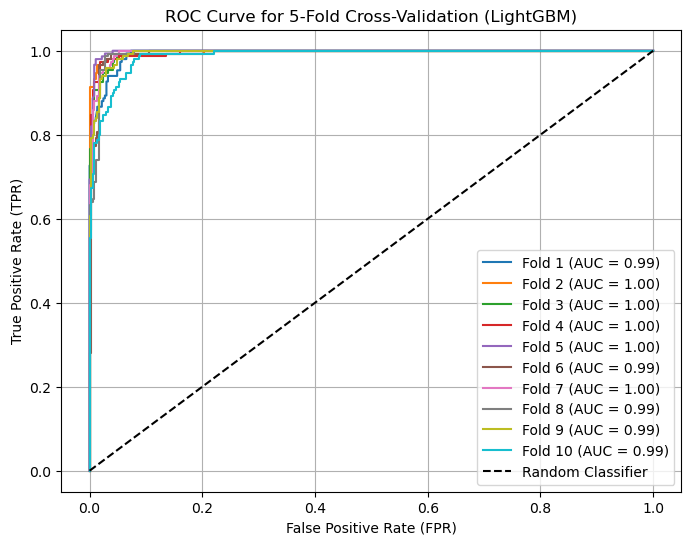

In [99]:
TP = lgbm_results_df["TP"].values
TN = lgbm_results_df["TN"].values
FP = lgbm_results_df["FP"].values
FN = lgbm_results_df["FN"].values

# Compute False Positive Rate (FPR) and True Positive Rate (TPR)
FPR = FP / (FP + TN)
TPR = TP / (TP + FN)

plt.figure(figsize=(8, 6))
folds = lgbm_results_df['Fold'].unique()
auc_scores = []

for fold in folds:
    fold_data = lgbm_results_df[lgbm_results_df['Fold'] == fold]
    y_true = fold_data['y_true'].values
    y_score = fold_data['y_score'].values

    # Compute ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)

    # Plot ROC for this fold
    plt.plot(fpr, tpr, label=f'Fold {fold} (AUC = {roc_auc:.2f})')

# Plot diagonal (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

# Plot settings
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for 5-Fold Cross-Validation (LightGBM)")
plt.legend()
plt.grid()

plt.show()

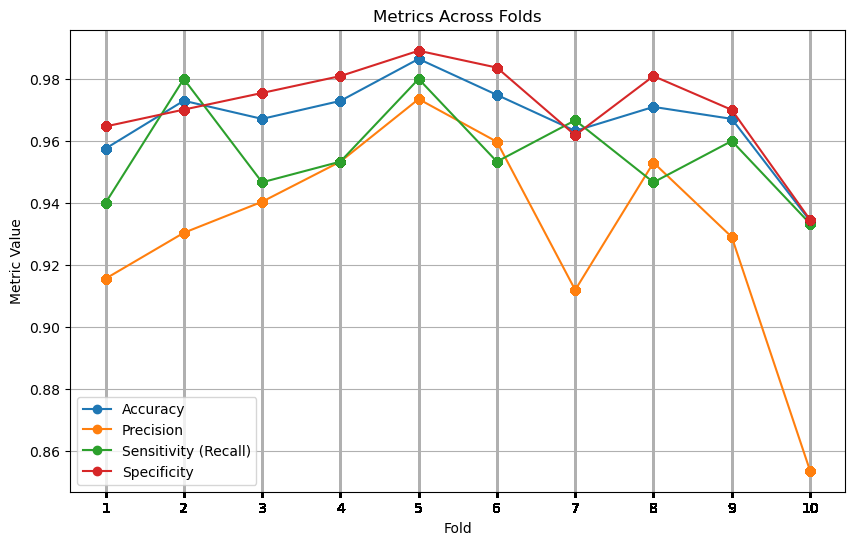

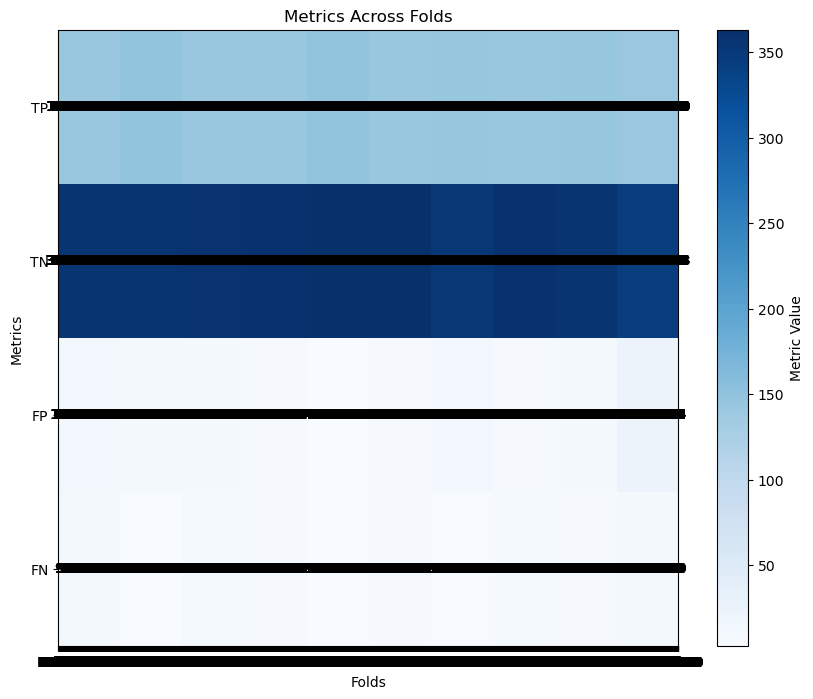

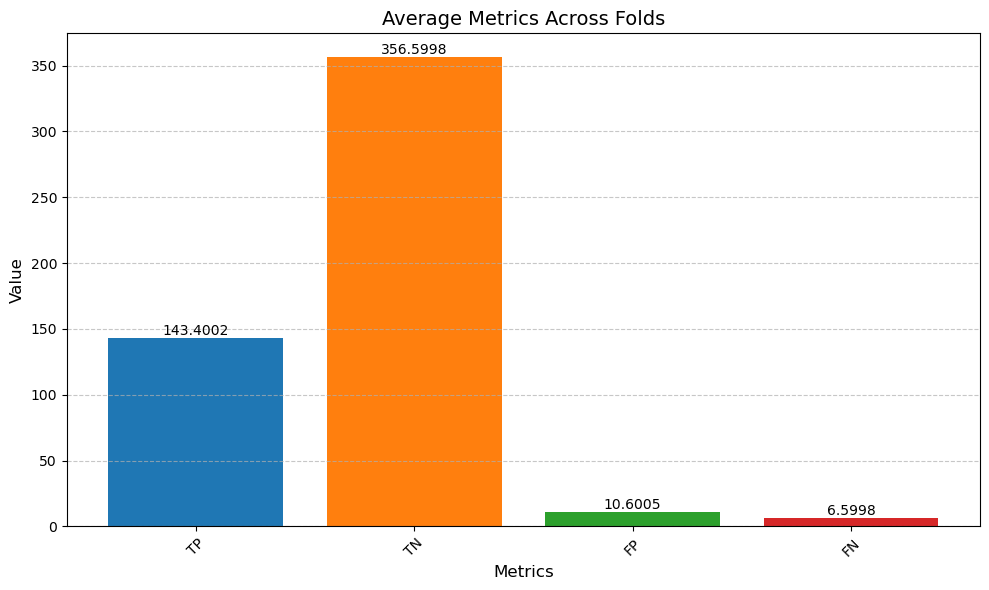

In [100]:
# Uncomment one of the lines below to get the visualisations for the corresponding model
plotting_df = lgbm_results_df
# plotting_df = rf_results_df

# 1. Line Plot for all metrics across folds
metrics_labels = ['Accuracy', 'Precision', 'Sensitivity (Recall)', 'Specificity']

plt.figure(figsize=(10, 6))
for metric in metrics_labels:
    plt.plot(plotting_df['Fold'], plotting_df[metric], marker='o', label=metric)
plt.title('Metrics Across Folds')
plt.xlabel('Fold')
plt.ylabel('Metric Value')
plt.xticks(plotting_df['Fold'])
plt.legend()
plt.grid()
plt.show()

# 2. # Extract metrics as rows and folds as columns
alarms = ['TP', 'TN', 'FP', 'FN']
metrics_df = plotting_df[alarms].T  # Transpose to have metrics as rows and folds as columns
metrics_df.columns = [f'Fold {fold}' for fold in plotting_df['Fold']]

# Plot a heatmap for metrics vs folds
plt.figure(figsize=(10, 8))
plt.imshow(metrics_df, cmap='Blues', aspect='auto', interpolation='nearest')
plt.colorbar(label='Metric Value')
plt.title('Metrics Across Folds')
plt.xlabel('Folds')
plt.ylabel('Metrics')
plt.xticks(range(len(metrics_df.columns)), metrics_df.columns)
plt.yticks(range(len(metrics_df.index)), metrics_df.index)

# Add values on the heatmap
for i in range(len(metrics_df.index)):
    for j in range(len(metrics_df.columns)):
        plt.text(j, i, f'{metrics_df.iloc[i, j]:.4f}' if metrics_df.index[i] not in ['TP', 'TN', 'FP', 'FN'] else f'{int(metrics_df.iloc[i, j])}',
                 ha='center', va='center', color='black')

plt.show()

# 3. Average Bar Plot for each metric
avg_metrics = plotting_df[alarms].mean()

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(
    avg_metrics.index,  # Metric names
    avg_metrics.values,  # Average values
    color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'],  # Custom colors
)

# Add value annotations above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Horizontal position
        yval,  # Vertical position
        f'{yval:.4f}',  # Format the value
        ha='center', va='bottom', fontsize=10  # Center alignment
    )

# Add title, labels, and grid lines
plt.title('Average Metrics Across Folds', fontsize=14)
plt.ylabel('Value', fontsize=12)
plt.xlabel('Metrics', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

The comparison between LGBM and Random Forest shows that both models perform similarly, but with slight variations in key metrics. LGBM tends to achieve higher accuracy and specificity, meaning it is better at correctly identifying negative cases while minimizing false positives. This makes it a good choice if avoiding false alarms is a priority.

On the other hand, Random Forest excels in precision and recall, making it slightly better at correctly identifying true positives. It also has fewer false negatives than LGBM, which means it is less likely to miss actual positive cases. This makes Random Forest a better choice when detecting positive instances is more important than avoiding false alarms.

Overall, both models perform well, but the choice between them depends on whether reducing false positives (LGBM) or false negatives (Random Forest) is more critical for the specific application.

Bogdan Kosev, 961324008
GitHub - https://github.com/B-Kosev/ml-project